<a href="https://colab.research.google.com/github/m-pedram/kaggleCovid/blob/main/Flu_ICU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet
!pip install xgboost --quiet
!pip install hyperopt --quiet
!pip install mlxtend --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.2 MB/s eta 0:00:00


In [ ]:
# Import modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
import matplotlib.ticker as ticker
import functools
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from google.colab import files
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
# read data from Google Drive
# from google.colab import drive 
# drive.mount('/content/drive')

# data = pd.read_csv('https://raw.githubusercontent.com/m-pedram/kaggleCovid/main/Report03/rawData.csv')
data = pd.read_csv('https://raw.githubusercontent.com/m-pedram/kaggleCovid/main/extra/2_Raw_data_RespInfo_for_analysis_OSF_cleaned.csv', delimiter=';')
filledData = data.fillna(method='pad')
filledData

,UISN,age,sex,LOS,Season,ILI_Symp,RSV,Influenza,RSV_Noso_MD,Influenza_Noso_MD,...,CRP,Lc,Crea,SpO2_percent,BP_syst,HR,Temp,BMI,Precondition,ICU_ADM
0,R001,0.814433,0,0.272727,0,1,0,1,0,1,...,0.312857,0.217687,0.152857,0.90,0.125,0.084,0.378,0.184,1,1
1,R002,0.288660,0,0.036364,0,1,0,1,0,0,...,0.312857,0.095238,0.122857,0.96,0.102,0.090,0.391,0.184,0,0
2,R003,0.701031,0,0.636364,0,1,0,1,0,0,...,0.127143,0.274376,0.287143,0.97,0.207,0.144,0.376,0.248,1,1
3,R004,0.835052,1,0.309091,0,1,0,1,0,0,...,0.057143,0.147392,0.120000,0.91,0.167,0.077,0.373,0.232,1,0
4,R005,0.752577,1,0.072727,0,1,0,1,0,0,...,0.018571,0.104308,0.158571,0.92,0.143,0.095,0.399,0.232,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,R544,0.886598,0,0.527273,1,1,1,0,0,0,...,0.052857,0.097506,0.097143,0.94,0.122,0.069,0.379,0.278,1,1
544,R545,0.608247,1,0.109091,1,1,1,0,0,0,...,0.044286,0.199546,0.082857,0.96,0.154,0.090,0.372,0.357,1,0
545,R546,0.896907,1,0.218182,1,1,1,0,0,0,...,0.172857,0.287982,0.072857,0.95,0.129,0.078,0.383,0.214,0,0
546,R547,0.680412,0,0.236364,1,1,1,0,0,0,...,0.125714,0.299320,0.104286,0.98,0.100,0.083,0.390,0.262,1,0


In [ ]:
Patient_Visit_Identifier = filledData['UISN']
filledData.drop( ['UISN'], axis = 1, inplace = True)
patients_admitted = filledData['ICU_ADM'].sum()/ len(filledData)
print('Percentage of patients admitted to ICU : {:.2f}%'.format (patients_admitted*100))
filledData.fillna(method='ffill', inplace = True) # ffill forward filling of nulls
filledData.fillna(method='bfill', inplace = True) # bfill backward filling of nulls for the values in the first rows
filledData.isna().sum().all() 
# remove duplicate rows
print(filledData.duplicated().sum())
filledData.drop_duplicates(inplace = True)
filledData.duplicated().sum()
filledData.info(verbose= True)
ICU_admitted = filledData['ICU_ADM']
filledData.drop( ['ICU_ADM'], axis = 1, inplace = True)

Percentage of patients admitted to ICU : 10.40%
0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 0 to 547
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 548 non-null    float64
 1   sex                 548 non-null    int64  
 2   LOS                 548 non-null    float64
 3   Season              548 non-null    int64  
 4   ILI_Symp            548 non-null    int64  
 5   RSV                 548 non-null    int64  
 6   Influenza           548 non-null    int64  
 7   RSV_Noso_MD         548 non-null    int64  
 8   Influenza_Noso_MD   548 non-null    int64  
 9   RSV_Noso_MCD        548 non-null    int64  
 10  Influenza_Noso_MCD  548 non-null    int64  
 11  CRP                 548 non-null    float64
 12  Lc                  548 non-null    float64
 13  Crea                548 non-null    float64
 14  SpO2_percent        548 non-null    float64
 15  BP_syst

In [ ]:
plt.style.use("fivethirtyeight")
%matplotlib inline

In [ ]:
#Define function to test algorithm
def score_model(estimator, train_data, validation_data, cv):
    #Unpack data
    X_train, y_train = train_data
    X_validation, y_validation = validation_data
    estimate = estimator
    #Perfomed cross-validation on train data
    model_cv = cross_validate(estimator = estimator, X = X_train, y = y_train,
                              scoring = ['accuracy', 'f1', 'roc_auc'],
                              cv = cv)
   
   # Generate a no skill prediction (majority class)
    no_skill_probs = [0 for _ in range(len(y_validation))]

    #Apply model to validation data
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_validation)

    # predict probabilities
    estimator_probs = estimator.predict_proba(X_validation)

    # keep probabilities for the positive outcome only
    estimator_probs = estimator_probs[:,1]

    # calculate scores
    no_skill_auc = roc_auc_score(y_validation, no_skill_probs)
    estimator_auc = roc_auc_score(y_validation, estimator_probs)

    #Print results
    print('CV model accuracy:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_accuracy'].mean()*100, model_cv['test_accuracy'].std()*100))
    print('CV model f_1 score:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_f1'].mean()*100, model_cv['test_f1'].std()*100))
    print('CV model roc_auc:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_roc_auc'].mean()*100, model_cv['test_roc_auc'].std()*100))
    print('Validation accuracy score: %{:.2f}'.format(accuracy_score(y_validation, y_pred)*100))
    print('Validation f_1 score: %{:.2f}'.format(f1_score(y_validation, y_pred)*100))
    print('Validation ROC_AUC score: %{:.2f}'.format(roc_auc_score(y_validation, y_pred)*100))

    print("--------")
    
    # summarize scores
    print('No Skill: ROC AUC=%{:.3f}'.format((no_skill_auc)*100))
    print('{}: ROC AUC=%{:.3f}'.format(estimator , (estimator_auc)*100))

    # calculate roc curves
    no_skill_fpr, no_skill_tpr, _ = roc_curve(y_validation, no_skill_probs)
    estimator_fpr, estimator_tpr, _ = roc_curve(y_validation, estimator_probs)

    # plot the roc curve for the model
    # plt.figure(figsize=(4,2))
    # fig = plt.gcf()
    # plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
    # plt.plot(estimator_fpr, estimator_tpr, marker='.', label=estimator)

    # # axis labels
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')

    # # show the legend
    # plt.legend()
    result_to_show = [round(accuracy_score(y_validation, y_pred), 2), 
    round(f1_score(y_validation, y_pred), 2), 
    round(roc_auc_score(y_validation, y_pred),2), round(estimator_auc, 2)]
    print(result_to_show)
    
    # show the plot
    # plt.show()
    
    return estimator, estimator_auc, result_to_show

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n = 100
results = np.zeros((4, 4, n))

for i in range(n):
  s = int(np.random.rand(1) * 100)
  np.random.seed(s)
  X = filledData
  y = ICU_admitted

  X_train, X_validation, y_train, y_validation = train_test_split(
      X, y, test_size=0.3, shuffle=True)

  # perform computation on data with reduced dimension
  pca = PCA(n_components=10, svd_solver='full')
  scaler = StandardScaler()
  scaler.fit(filledData)
  df_new_scaled = scaler.transform(filledData)
  X_reduced = pca.fit_transform(df_new_scaled)
  np.random.seed(s)

  X_reduced_train, X_reduced_validation, y_train, y_validation = train_test_split(
      X_reduced, y, test_size=0.3, shuffle=True)

  model_1 = LogisticRegression(max_iter=500)
  model_2 = SVC(max_iter=500, probability=True)
  model_3 = RandomForestClassifier(n_estimators=100, criterion='entropy',
                                  max_depth=None, max_features='sqrt')
  model_4 = XGBClassifier(n_estimators=100, criterion='gini', 
                          max_features='sqrt')

  fitted_baseline_model_1, estimator_auc_1, dt_1 = score_model(
    estimator=model_1,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)
  fitted_baseline_model_2, estimator_auc_2, dt_2 = score_model(
    estimator=model_2,
                    train_data=(X_reduced_train, y_train),
                    validation_data=(
                        X_reduced_validation, y_validation),
                    cv=10)
  fitted_baseline_model_3, estimator_auc_3, dt_3 = score_model(
    estimator=model_3,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)

  fitted_baseline_model_4, estimator_auc_4, dt_4 = score_model(
    estimator=model_4,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)
    
  results[:, 0, i] = np.array(dt_1).T
  results[:, 1, i] = np.array(dt_2).T
  results[:, 2, i] = np.array(dt_3).T
  results[:, 3, i] = np.array(dt_4).T

CV model accuracy:  %89.30 +/- %0.71
CV model f_1 score:  %0.00 +/- %0.00
CV model roc_auc:  %77.05 +/- %14.25
Validation accuracy score: %89.70
Validation f_1 score: %0.00
Validation ROC_AUC score: %50.00
--------
No Skill: ROC AUC=%50.000
LogisticRegression(max_iter=500): ROC AUC=%67.289
[0.9, 0.0, 0.5, 0.67]


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


CV model accuracy:  %89.30 +/- %0.71
CV model f_1 score:  %0.00 +/- %0.00
CV model roc_auc:  %79.91 +/- %14.30
Validation accuracy score: %89.09
Validation f_1 score: %0.00
Validation ROC_AUC score: %49.66
--------
No Skill: ROC AUC=%50.000
SVC(max_iter=500, probability=True): ROC AUC=%67.250
[0.89, 0.0, 0.5, 0.67]
CV model accuracy:  %90.36 +/- %2.80
CV model f_1 score:  %17.33 +/- %27.36
CV model roc_auc:  %77.05 +/- %16.05
Validation accuracy score: %89.70
Validation f_1 score: %0.00
Validation ROC_AUC score: %50.00
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(criterion='entropy'): ROC AUC=%80.564
[0.9, 0.0, 0.5, 0.81]
[22:27:24] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:27:24] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:27:24] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:27:24] WARNING: ../src/learner.cc:767: 
Para

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Parameters: { "criterion", "max_features" } are not used.

[22:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

[22:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.

CV model accuracy:  %90.09 +/- %2.24
CV model f_1 score:  %16.67 +/- %21.08
CV model roc_auc:  %77.90 +/- %10.34
Validation accuracy score: %87.88
Validation f_1 score: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

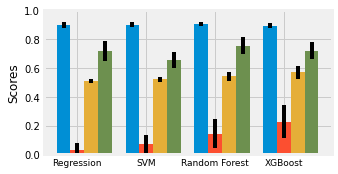

In [ ]:
X = 1.25 * np.arange(4) 
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, np.mean(results[0], axis=1), yerr=np.std(results[0], axis=1), width = 0.25)
ax.bar(X + 0.25, np.mean(results[1], axis=1), yerr=np.std(results[1], axis=1),width = 0.25)
ax.bar(X + 0.50, np.mean(results[2], axis=1), yerr=np.std(results[2], axis=1),width = 0.25)
ax.bar(X + 0.75, np.mean(results[3], axis=1), yerr=np.std(results[3], axis=1),width = 0.25)
ax.set_ylabel('Scores')
# ax.set_title('XGBoost')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('Regression', 'SVM', 'Random Forest', 'XGBoost'), fontdict={'size': 9})
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc_1', 'auc_2'])
fig.savefig('Flu_all_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('Flu_all_results.png')
plt.show()